In [ ]:
"""
Chakradhar Koppula

Convolutional Neural Network for Animal Classification.

This notebook aims to correctly classify an image as one of ten animals using a CNN. It trains for 15 epochs
on the Animals-10 Kaggle dataset (https://www.kaggle.com/alessiocorrado99/animals10).
"""

## Imports

In [2]:
# Imports needed for the notebook

import itertools
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Loading Datasets into Colab

In [5]:
# Datasets uploaded to personal Google Drive. Personal Drve then mounted to colab
# for easy access. In event of colab timeout no need to reuplaod entire dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Unzipping training and validation data from drive into colab workspace.
# Folders are named in Spanish.
!7z x "/content/drive/MyDrive/Data.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 613301814 bytes (585 MiB)

Extracting archive: /content/drive/MyDrive/Data.zip
 15% 4096 Open              --
Path = /content/drive/MyDrive/Data.zip
Type = zip
Physical Size = 613301814

  0%      1% 562 - Data/raw-img/cane/OIP-6AIl3KxbPulVJFYnZ6DWFwAAAA.jpeg                                                                  1% 905 - Data/raw-img/cane/OIP-a8Glfu3rJtNrgKcYMuoXNQHaE9.jpeg              

In [7]:
# Unzipping testing data from drive into colab workspace.
# Folders are named in Spanish.
!7z x "/content/drive/MyDrive/test.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 41956428 bytes (41 MiB)

Extracting archive: /content/drive/MyDrive/test.zip
--
Path = /content/drive/MyDrive/test.zip
Type = zip
Physical Size = 41956428

  0%     54% 489 - test/gatto/137.jpeg                               80% 723 - test/pecora/ea34b60c29fd033ed158 . 218ac104497f5c978a6e8b0b1_640.jpg                                                                               Everything is Ok

Fol

In [3]:
!ls Data/raw-img # Checking that I am able to access the folders correctly.

cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


In [4]:
!ls test # Checking that I am able to access the folders correctly

cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


## Constants

In [5]:
# Defining Constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 96
EPOCHS = 15
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
VALIDATION_SPLIT = 0.2

## Loading images into training and validation sets

In [6]:
# Creating ImageDataGenerator object in order to load in the training and validation data. 
img_data_gen = ImageDataGenerator(
    rescale=1./255,                     # Rescale used to normalize image values from between 0-255 to between 0-1.
    shear_range=SHEAR_RANGE,            # Shear range use to distort the image along an axis to augment images to accomadate for different viewing angles.
    zoom_range=ZOOM_RANGE,              # Zoom range applies a random zoom to the image to create a more varied dataset.
    horizontal_flip=True,               # Horizontal flip randomly flips images horizontally to create a more varied dataset.
    validation_split=VALIDATION_SPLIT   # 20% of data is being used as validation data during the training process.
)

In [7]:
train_generator = img_data_gen.flow_from_directory(
    'Data/raw-img',
    subset="training",                       # Uses 80% of images in the directory as the training images.
    target_size = (IMG_HEIGHT, IMG_WIDTH),   # Resizes all images to be 256x256x3 (RGB).
    batch_size = BATCH_SIZE                  # Batch size of 96 used, found to be best after experimentation.
)

validation_generator = img_data_gen.flow_from_directory(
    'Data/raw-img',
    subset="validation",                     # Uses 20% of images in the directory as the validation images.
    target_size = (IMG_HEIGHT, IMG_WIDTH),   # Resizes all images to be 256x256x3 (RGB).
    batch_size = BATCH_SIZE                  # Batch size of 96 used, found to be best after experimentation.
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [8]:
# Animals in the dataset and their corresponding class indices.
# cane: Dog
# cavallo: Horse
# elefante: Elephant
# farfalla: Butterfly
# gallina: Hen
# gatto: Cat
# mucca: Cow
# pecora: Sheep
# ragno: Spider
# scoiattolo: Squirrel

train_generator.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

## Defining the model

In [9]:
# 4 Layers of image convolutions followed by 3 fully connected layers.
model = Sequential()

# First 2 convolutional layers learn 64 filters of size 3x3. After the convolutional layers is a max pooling 
# layer and then batch normalization is carried out.
model.add(Convolution2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Second 2 convolutional layers learn 128 filters of size 3x3. After the convolutional layers is a max pooling 
# layer and then batch normalization is carried out.
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Flatten the output into a single 1-D vector
model.add(Flatten())

# ANN layers with dropout to prevent overfitting.
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))

# Final layer with 10 output for the 10 classes. Softmax used due ot multiclass classification being done.
model.add(Dense(units=10, activation='softmax'))

In [10]:
# Using categorical_crossentropy as I am carrying out multiclass classification.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

## Training the model

In [11]:
# Train model. Takes around 2.5-3.0 hours to train on Colab with GPU.
history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, batch_size=BATCH_SIZE)

Epoch 1/15
219/219 [==============================] - 374s 2s/step - loss: 2.7930 - accuracy: 0.2085 - val_loss: 2.2961 - val_accuracy: 0.2328
Epoch 2/15
219/219 [==============================] - 366s 2s/step - loss: 1.7537 - accuracy: 0.4022 - val_loss: 2.2004 - val_accuracy: 0.2209
Epoch 3/15
219/219 [==============================] - 368s 2s/step - loss: 1.4709 - accuracy: 0.5009 - val_loss: 2.0178 - val_accuracy: 0.3649
Epoch 4/15
219/219 [==============================] - 366s 2s/step - loss: 1.3037 - accuracy: 0.5579 - val_loss: 2.1026 - val_accuracy: 0.3943
Epoch 5/15
219/219 [==============================] - 366s 2s/step - loss: 1.1860 - accuracy: 0.6018 - val_loss: 1.3581 - val_accuracy: 0.5357
Epoch 6/15
219/219 [==============================] - 366s 2s/step - loss: 1.0612 - accuracy: 0.6483 - val_loss: 1.2493 - val_accuracy: 0.5921
Epoch 7/15
219/219 [==============================] - 365s 2s/step - loss: 0.9585 - accuracy: 0.6851 - val_loss: 1.2603 - val_accuracy: 0.6028

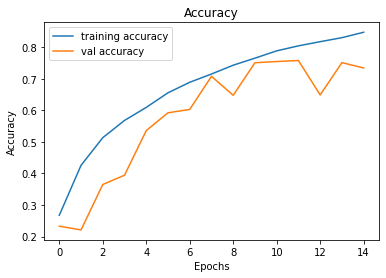

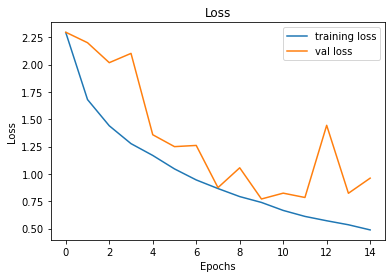

In [12]:
# Plotting graph for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Saving the model.
model.save('model.h5')

## Testing the model

In [14]:
# Using same transformations used in the training sets.
img_data_gen2 = ImageDataGenerator(
    rescale=1./255,           # Rescale used to normalize image values from between 0-255 to between 0-1.
    shear_range=SHEAR_RANGE,  # Shear range use to distort the image along an axis to augment images to accomadate for different viewing angles.
    zoom_range=ZOOM_RANGE,    # Zoom range applies a random zoom to the image to create a more varied dataset.
    horizontal_flip=True,     # Horizontal flip randomly flips images horizontally to create a more varied dataset.
)

# Shuffle set to false so that index of predictions correspond to the index of actual labels when used later on.
test_generator = img_data_gen2.flow_from_directory(
    'test',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle=False
)            

Found 900 images belonging to 10 classes.


In [15]:
# Evaluate performance against test set and work out accuracy and loss.
model.evaluate(test_generator, batch_size=BATCH_SIZE)

10/10 [==============================] - 13s 1s/step - loss: 0.6833 - accuracy: 0.7667


[0.6833397746086121, 0.7666666507720947]

## Confusion matrix and Metrics

In [16]:
test_labels = test_generator.classes    # Actual labels for each input image.
preds = model.predict(test_generator)   # Predicted probability distributions for each input image.
y_preds = np.argmax(preds, axis=-1)     # Predicted labels for each input image. (takes largest proability as predicted label)

In [17]:
# Calculate metrics such as Precision, Recall and F1-Score.
animals = ['Dog', 'Horse', 'Elephant', 'Butterfly', 'Chicken', 'Cat', 'Cow', 'Sheep', 'Spider', 'Squirrel']
print(metrics.classification_report(test_labels, y_preds, target_names=animals))

              precision    recall  f1-score   support

         Dog       0.73      0.73      0.73        90
       Horse       0.95      0.60      0.73        90
    Elephant       0.60      0.99      0.75        90
   Butterfly       0.94      0.73      0.83        90
     Chicken       0.93      0.86      0.89        90
         Cat       0.94      0.72      0.82        90
         Cow       0.81      0.60      0.69        90
       Sheep       0.58      0.78      0.66        90
      Spider       0.73      0.93      0.82        90
    Squirrel       0.81      0.72      0.76        90

    accuracy                           0.77       900
   macro avg       0.80      0.77      0.77       900
weighted avg       0.80      0.77      0.77       900



In [18]:
confusion_matrix = confusion_matrix(test_labels, y_preds) # Work out confusion matrix.

In [19]:
def pretty_confusion_matrix(confusion_matrix, classes, normalise=False):
    '''
    @param confusion_matrix: The confusion matrix produced by sk-learn to be made more visualy informative and pleasing.
    @param classes: The names of the class labels.
    @param normalise: Flag to determine whther or not to display normalised values instead of occurences in the confusion matrix.
    '''
    
    if normalise:
        print('Normalised', end=' ')
        # Divides each cell by the sum of the row
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print('Confusion Matrix')

    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.title('Confusion Matrix')
    # Show confusion matrix using Blue accent colour as an image with varying colour intensities depending on value.
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
    plt.colorbar() # Add colourbar showing what the intensity of colour represents.
    ticks = np.arange(len(classes)) # generate list of numbers upto the number of classes involved.
    plt.xticks(ticks, classes, rotation=45) # X-axis with rotated labels for readability. (Predicted labels)
    plt.yticks(ticks, classes) # Y-axis with labels (Actual labels)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    text_colour_threshold = np.max(confusion_matrix) / 2.0 # Value for which text colour on cell changes from black to white for visibility.
    
    # For each cell, writes the value of the cell in either black or white depending on what is best for visibility.
    for row, col in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(col, row, format(confusion_matrix[row, col], '.2f'), horizontalalignment="center", color="white" if confusion_matrix[row, col] > text_colour_threshold else "black")

Confusion Matrix


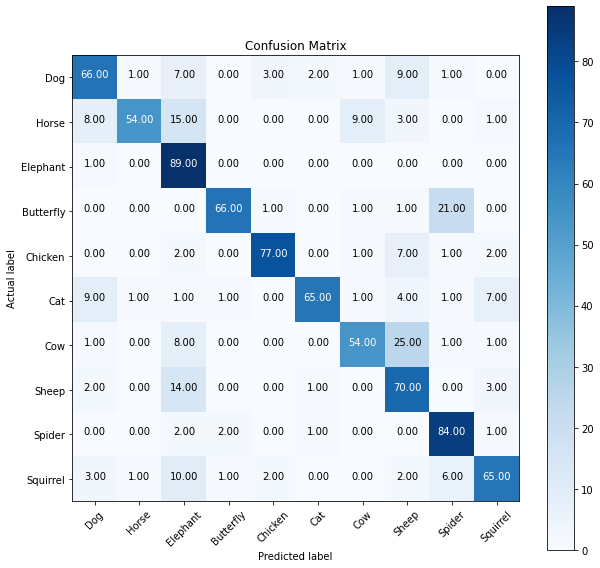

In [20]:
pretty_confusion_matrix(confusion_matrix, animals)

Normalised Confusion Matrix


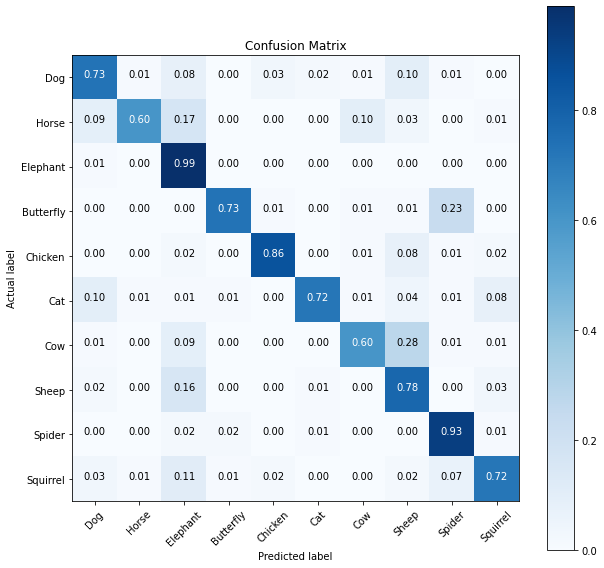

In [21]:
pretty_confusion_matrix(confusion_matrix, animals, normalise=True)